In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout

Using TensorFlow backend.


In [2]:
train_data = pd.read_excel(r'C:\Users\Adam\Desktop\Food Quality\data\Data_Train.xlsx', sheet_name=0)
test_data = pd.read_excel(r'C:\Users\Adam\Desktop\Food Quality\data\Data_Test.xlsx', sheet_name=0)

train_data.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4
2,40148966010272,01-05-2013,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,NaN,High,locid3368,6
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31.0,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30.0,High,locid12264,4


In [3]:
train_data.columns = train_data.columns.str.lower()

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
id                    147443 non-null int64
date                  147443 non-null object
licenseno             147443 non-null int64
facilityid            147443 non-null int64
facilityname          147443 non-null int64
type                  143958 non-null object
street                147443 non-null int64
city                  147443 non-null object
state                 147443 non-null object
locationid            147408 non-null float64
reason                147443 non-null object
sectionviolations     108375 non-null float64
risklevel             147443 non-null object
geo_loc               147443 non-null object
inspection_results    147443 non-null int64
dtypes: float64(2), int64(6), object(7)
memory usage: 16.9+ MB


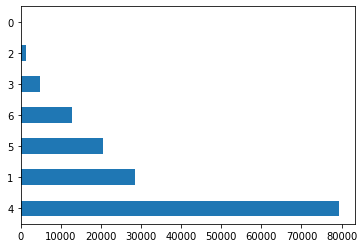

In [5]:
#classes are highly imbalanced, if trained a basic model it predicts class : 4 often
train_data.inspection_results.value_counts().plot(kind='barh')

In [6]:
train_data[train_data['sectionviolations'].isnull()]['reason'].value_counts()

CANVASS                                   18422
LICENSE                                    7548
CANVASS RE-INSPECTION                      4376
LICENSE RE-INSPECTION                      3881
COMPLAINT RE-INSPECTION                    1615
SHORT FORM COMPLAINT                       1362
COMPLAINT                                   828
LICENSE-TASK FORCE                          226
OUT OF BUSINESS                             220
CONSULTATION                                201
TASK FORCE LIQUOR 1475                      116
TAG REMOVAL                                  84
RECENT INSPECTION                            67
SUSPECTED FOOD POISONING RE-INSPECTION       36
SHORT FORM FIRE-COMPLAINT                    35
COMPLAINT-FIRE                               27
SUSPECTED FOOD POISONING                     24
Name: reason, dtype: int64

In [7]:
train_data.reason.value_counts()

CANVASS                                   77943
LICENSE                                   19645
CANVASS RE-INSPECTION                     15705
COMPLAINT                                 13572
LICENSE RE-INSPECTION                      6796
COMPLAINT RE-INSPECTION                    5655
SHORT FORM COMPLAINT                       5094
SUSPECTED FOOD POISONING                    631
CONSULTATION                                503
TAG REMOVAL                                 456
LICENSE-TASK FORCE                          444
RECENT INSPECTION                           248
OUT OF BUSINESS                             220
TASK FORCE LIQUOR 1475                      187
SUSPECTED FOOD POISONING RE-INSPECTION      147
COMPLAINT-FIRE                              120
SHORT FORM FIRE-COMPLAINT                    77
Name: reason, dtype: int64

In [345]:
(train_data[train_data['sectionviolations'].isnull()]['reason'].value_counts() / train_data.reason.value_counts() *100).sort_values(ascending=False)

OUT OF BUSINESS                           100.000000
TASK FORCE LIQUOR 1475                     62.032086
LICENSE RE-INSPECTION                      57.107122
LICENSE-TASK FORCE                         50.900901
SHORT FORM FIRE-COMPLAINT                  45.454545
CONSULTATION                               39.960239
LICENSE                                    38.421990
COMPLAINT RE-INSPECTION                    28.558798
CANVASS RE-INSPECTION                      27.863738
RECENT INSPECTION                          27.016129
SHORT FORM COMPLAINT                       26.737338
SUSPECTED FOOD POISONING RE-INSPECTION     24.489796
CANVASS                                    23.635221
COMPLAINT-FIRE                             22.500000
TAG REMOVAL                                18.421053
COMPLAINT                                   6.100796
SUSPECTED FOOD POISONING                    3.803487
Name: reason, dtype: float64

In [346]:
df = train_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
id                    147443 non-null int64
date                  147443 non-null object
licenseno             147443 non-null int64
facilityid            147443 non-null int64
facilityname          147443 non-null int64
type                  143958 non-null object
street                147443 non-null int64
city                  147443 non-null object
state                 147443 non-null object
locationid            147408 non-null float64
reason                147443 non-null object
sectionviolations     108375 non-null float64
risklevel             147443 non-null object
geo_loc               147443 non-null object
inspection_results    147443 non-null int64
dtypes: float64(2), int64(6), object(7)
memory usage: 16.9+ MB


In [347]:
len(df)

147443

In [348]:
df.sectionviolations.isna().sum()

39068

In [349]:
df.columns

Index(['id', 'date', 'licenseno', 'facilityid', 'facilityname', 'type',
       'street', 'city', 'state', 'locationid', 'reason', 'sectionviolations',
       'risklevel', 'geo_loc', 'inspection_results'],
      dtype='object')

In [350]:
indexes = df.loc[pd.to_datetime(df.date, format = '%d-%m-%Y', errors='coerce').isna()].index
for i in indexes:
    df.iloc[i,1] = df.iloc[i,1].replace('29-02','01-03')

In [351]:
df['date'] = pd.to_datetime(df.date, format='%d-%m-%Y')

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
id                    147443 non-null int64
date                  147443 non-null datetime64[ns]
licenseno             147443 non-null int64
facilityid            147443 non-null int64
facilityname          147443 non-null int64
type                  143958 non-null object
street                147443 non-null int64
city                  147443 non-null object
state                 147443 non-null object
locationid            147408 non-null float64
reason                147443 non-null object
sectionviolations     108375 non-null float64
risklevel             147443 non-null object
geo_loc               147443 non-null object
inspection_results    147443 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(6)
memory usage: 16.9+ MB


In [353]:
df['type'] = df.groupby('facilityname')['type'].ffill()
df['type'] = df.groupby('facilityname')['type'].bfill()

df['type'] = df.type.fillna("UNKOWN")

In [354]:
df.loc[(df.type.str.lower().str.contains('care')) | (df.type.str.lower().str.contains('livi')),'type'] = 'CARE CENTERS'
df.loc[df.type.str.lower().str.contains('mobil'), 'type'] = 'MOBILE FOOD VENDOR'
df.loc[df.type.str.lower().str.contains('hospital'), 'type'] = 'HOSPITAL'
df.loc[df.type.str.lower().str.contains('banquet'), 'type'] = 'BANQUET'
df.loc[(df.type.str.lower().str.contains('rest')) | (df.type.str.lower().str.contains('roof')), 'type'] = 'RESTAURANT'
df.loc[(df.type.str.lower().str.contains('cafe')) | (df.type.str.lower().str.contains('coffee')), 'type'] = 'CAFE'
df.loc[(df.type.str.lower().str.contains('liq')) | (df.type.str.lower().str.contains('bar')) , 'type'] = 'BAR'
df.loc[(df.type.str.lower().str.contains('kiosk'))|(df.type.str.lower().str.contains('froze'))
       | (df.type.str.lower().str.contains('food')), 'type'] = 'FOOD VENDING MACHINES'
df.loc[df.type.str.lower().str.contains('gas'), 'type'] = 'GAS STATION'
df.loc[df.type.str.lower().str.contains('grocery'), 'type'] = 'GROCERY'
df.loc[df.type.str.lower().str.contains('school'), 'type'] = 'SCHOOL'
df.loc[df.type.str.lower().str.contains('kitch'), 'type'] = 'SHARED KITCHEN'
df.loc[df.type.str.lower().str.contains('conv'), 'type'] = 'CONVENIENCE STORES'
df.loc[df.type.str.lower().str.contains('prof'), 'type'] = 'NON PROFITS'
df.loc[df.type.str.lower().str.contains('theat'), 'type'] = 'THEATER'
df.loc[df.type.str.lower().str.contains('poul'), 'type'] = 'POULTRY'

lst = ['RESTAURANT', 'GROCERY', 'SCHOOL', 'CARE CENTERS', 'UNKOWN', 'BAKERY', 
       'FOOD VENDING MACHINES', 'CATERING', 'BAR', 'HOSPITAL', 'GOLDEN DINER', 
       'WHOLESALE', 'SHARED KITCHEN', 'BANQUET', 'TAVERN', 'GAS STATION', 'SPECIAL EVENT', 
       'CAFE', 'CONVENIENCE STORES', 'POULTRY', 'SHELTER', 'THEATER', 'STADIUM', 'STORE', 
       'ICE CREAM SHOP']
df.loc[~df.type.isin(lst),'type'] = 'OTHER OUTLETS'

In [355]:
df['city'] = df.city.str.replace(r'[^0-9]','').astype('int')
df['state'] = df.state.str.replace(r'[^0-9]','').astype('int')

In [362]:
df['sectionviolations'].fillna(df.groupby('facilityname')['sectionviolations'].agg(pd.Series.mode),
                                                        inplace=True)
df['sectionviolations'].fillna(df.groupby('reason')['sectionviolations'].agg(pd.Series.mode),
                                                        inplace=True)

Exception: Must produce aggregated value

In [361]:
df.groupby('reason')['sectionviolations'].agg(pd.Series.mode)

reason
CANVASS                                   32.0
CANVASS RE-INSPECTION                     32.0
COMPLAINT                                 32.0
COMPLAINT RE-INSPECTION                   32.0
COMPLAINT-FIRE                            32.0
CONSULTATION                              32.0
LICENSE                                   32.0
LICENSE RE-INSPECTION                     32.0
LICENSE-TASK FORCE                         2.0
OUT OF BUSINESS                           33.0
RECENT INSPECTION                          3.0
SHORT FORM COMPLAINT                      32.0
SHORT FORM FIRE-COMPLAINT                 32.0
SUSPECTED FOOD POISONING                   3.0
SUSPECTED FOOD POISONING RE-INSPECTION    32.0
TAG REMOVAL                               32.0
TASK FORCE LIQUOR 1475                    18.0
Name: sectionviolations, dtype: float64